## Demo: resource synchronization
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

Synchronization of resources means that before objects can be moved from one location to another, the processor as well as the origin and the destination resource must be available. If a resource is not available the process will wait untill the resource available.

Currently this waiting time is not recorded in the logs. The waiting time can be derived from the activity log by identifying time differences between the completion of an activity and the start of the subsequent activity.

This is an incomplete feature since preserve reservations can not be released automatically. Recommendation is to have a request_resource and a release_resource activity.

The current mechanism is based on two attributes of activities
- **keep_resources** a list of resources, which should not be released at the end of an activity
- **reserved_resources** is a dictionary, should be initialized for all activities of a process with the same variable. This will enable the transfer of reserved resources from one activity to another one.

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 10,
                  "level": 8
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

##### 3.2. Create vessel object(s)

In [5]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 1,
                 "unloading_rate": 1,
                 "capacity": 4,
                 "compute_v": lambda x: 10
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

# prepare input data for vessel_02
data_vessel02 = {"env": my_env,
                 "name": "vessel02",
                 "geometry": location_from_site, 
                 "loading_rate": 1,
                 "unloading_rate": 1,
                 "capacity": 4,
                 "compute_v": lambda x: 10
               }
# instantiate vessel_02 
vessel02 = TransportProcessingResource(**data_vessel02)

##### 3.3 Create activity/activities
Then **requested_resources1** variable is used to initialize all activities below. This enables the transfer of reserved resources to the next activity.

The **keep_resources** parameter tells that after hopper1 has received an object from *from_site* it should not release the *from_site* resource.

In [6]:
# initialise registry and keep_resources
registry = {}
keep_resources = {}

In [7]:
requested_resources1 = {}
activity1 = model.ShiftAmountActivity(
    env=my_env,
    name="Transfer 1",
    registry=registry,
    processor=vessel01,
    origin=from_site,
    destination=vessel01,
    amount=1,
    duration=20,
    requested_resources=requested_resources1,
)

seq_activity1 = model.SequentialActivity(
    env=my_env,
    name="Sequential process 1",
    registry=registry,
    sub_processes=[activity1],
    requested_resources=requested_resources1,
)

while1 = model.WhileActivity(
    env=my_env,
    name="While 1",
    registry=registry,
    sub_processes=[seq_activity1],
    requested_resources=requested_resources1,
    condition_event=[
        {
            "or": [
                {"type": "container", "concept": vessel01, "state": "full"},
                {"type": "container", "concept": from_site, "state": "empty"},
            ]
        }
    ],
)

The second activity is a normal process without special parameters.

In [8]:
activity2 = model.ShiftAmountActivity(
    env=my_env,
    name="Transfer 2",
    registry=registry,
    processor=vessel02,
    origin=from_site,
    destination=vessel02,
    amount=1,
    duration=20,
)

seq_activity2 = model.SequentialActivity(
    env=my_env,
    name="Sequential process 2",
    registry=registry,
    sub_processes=[activity2],
)
while2 = model.WhileActivity(
    env=my_env,
    name="While 2",
    registry=registry,
    sub_processes=[seq_activity2],
    condition_event=[
        {
            "or": [
                {"type": "container", "concept": vessel02, "state": "full"},
                {"type": "container", "concept": from_site, "state": "empty"},
            ]
        }
    ],
)

#### 4. Register processes and run simpy

In [9]:
# initate the simpy processes defined in the two 'while activities' and run simpy
model.register_processes([while1, while2])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [10]:
plot.get_log_dataframe(from_site, [while1, while2])

,Activity,Timestamp,ActivityState,container level,geometry
0,Transfer 1,1970-01-01 00:00:00,START,8,POINT (4.18055556 52.18664444)
1,Transfer 1,1970-01-01 00:00:20,STOP,7,POINT (4.18055556 52.18664444)
2,Transfer 2,1970-01-01 00:00:20,START,7,POINT (4.18055556 52.18664444)
3,Transfer 2,1970-01-01 00:00:40,STOP,6,POINT (4.18055556 52.18664444)
4,Transfer 1,1970-01-01 00:00:40,START,6,POINT (4.18055556 52.18664444)
5,Transfer 1,1970-01-01 00:01:00,STOP,5,POINT (4.18055556 52.18664444)
6,Transfer 2,1970-01-01 00:01:00,START,5,POINT (4.18055556 52.18664444)
7,Transfer 2,1970-01-01 00:01:20,STOP,4,POINT (4.18055556 52.18664444)
8,Transfer 1,1970-01-01 00:01:20,START,4,POINT (4.18055556 52.18664444)
9,Transfer 1,1970-01-01 00:01:40,STOP,3,POINT (4.18055556 52.18664444)


In [11]:
plot.get_log_dataframe(vessel01, [while1, while2])

,Activity,Timestamp,ActivityState,geometry,container level
0,Transfer 1,1970-01-01 00:00:00,START,POINT (4.18055556 52.18664444),0.0
1,Transfer 1,1970-01-01 00:00:20,STOP,POINT (4.18055556 52.18664444),1.0
2,Transfer 1,1970-01-01 00:00:40,START,POINT (4.18055556 52.18664444),1.0
3,Transfer 1,1970-01-01 00:01:00,STOP,POINT (4.18055556 52.18664444),2.0
4,Transfer 1,1970-01-01 00:01:20,START,POINT (4.18055556 52.18664444),2.0
5,Transfer 1,1970-01-01 00:01:40,STOP,POINT (4.18055556 52.18664444),3.0
6,Transfer 1,1970-01-01 00:02:00,START,POINT (4.18055556 52.18664444),3.0
7,Transfer 1,1970-01-01 00:02:20,STOP,POINT (4.18055556 52.18664444),4.0


In [12]:
plot.get_log_dataframe(vessel02, [while1, while2])

,Activity,Timestamp,ActivityState,geometry,container level
0,Transfer 2,1970-01-01 00:00:20,START,POINT (4.18055556 52.18664444),0.0
1,Transfer 2,1970-01-01 00:00:40,STOP,POINT (4.18055556 52.18664444),1.0
2,Transfer 2,1970-01-01 00:01:00,START,POINT (4.18055556 52.18664444),1.0
3,Transfer 2,1970-01-01 00:01:20,STOP,POINT (4.18055556 52.18664444),2.0
4,Transfer 2,1970-01-01 00:01:40,START,POINT (4.18055556 52.18664444),2.0
5,Transfer 2,1970-01-01 00:02:00,STOP,POINT (4.18055556 52.18664444),3.0
6,Transfer 2,1970-01-01 00:02:20,START,POINT (4.18055556 52.18664444),3.0
7,Transfer 2,1970-01-01 00:02:40,STOP,POINT (4.18055556 52.18664444),4.0


In [13]:
plot.get_log_dataframe(vessel02, [while1, while2])

,Activity,Timestamp,ActivityState,geometry,container level
0,Transfer 2,1970-01-01 00:00:20,START,POINT (4.18055556 52.18664444),0.0
1,Transfer 2,1970-01-01 00:00:40,STOP,POINT (4.18055556 52.18664444),1.0
2,Transfer 2,1970-01-01 00:01:00,START,POINT (4.18055556 52.18664444),1.0
3,Transfer 2,1970-01-01 00:01:20,STOP,POINT (4.18055556 52.18664444),2.0
4,Transfer 2,1970-01-01 00:01:40,START,POINT (4.18055556 52.18664444),2.0
5,Transfer 2,1970-01-01 00:02:00,STOP,POINT (4.18055556 52.18664444),3.0
6,Transfer 2,1970-01-01 00:02:20,START,POINT (4.18055556 52.18664444),3.0
7,Transfer 2,1970-01-01 00:02:40,STOP,POINT (4.18055556 52.18664444),4.0


Interesting in this scenario is that the process of hopper2 is not executed at all because hopper1 takes requests the resource *from_site* and never releases it again, thus hopper2 process can not start.

By commenting out the **keep_resource** parameter in shift amount activity of hopper1, will result in hopper1 and hopper2 getting access to the resource *from_site* one after each other.

##### 5.2 Visualise gantt charts

In [14]:
fig = plot.get_gantt_chart([from_site, vessel01, vessel02],id_map=[while1, while2])

##### 5.3 Visualise step charts

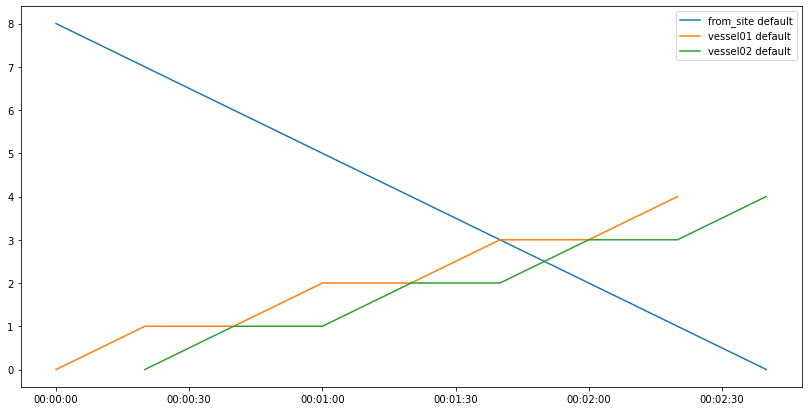

In [15]:
fig = plot.get_step_chart([from_site, vessel01, vessel02])